# Optimization Tutorial

Trey V. Wenger (c) April 2025

Here we demonstrate how to optimize the number of cloud components in a `EmissionAbsorptionModel` model.

In [1]:
# General imports    
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)
print("arviz version:", az.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import caribou_hi
print("caribou_hi version:", caribou_hi.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.22.0
arviz version: 0.22.0dev
bayes_spec version: 1.7.8
caribou_hi version: 2.0.1+0.g9e7964e.dirty


## Model Definition and Simulated Data

In [2]:
from bayes_spec import SpecData

# spectral axes definitions
emission_axis = np.linspace(-60.0, 60.0, 200)  # km s-1
absorption_axis = np.linspace(-30.0, 30.0, 100)  # km s-1

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms_emission = 0.1  # K
rms_absorption = 0.01  # 1 - exp(-tau)

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
emission = rms_emission * np.random.randn(len(emission_axis))
absorption = rms_absorption * np.random.randn(len(absorption_axis))

dummy_data = {
    "emission": SpecData(
        emission_axis,
        emission,
        rms_emission,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_B$ (K)",
    ),
    "absorption": SpecData(
        absorption_axis,
        absorption,
        rms_absorption,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"1 - exp(-$\tau$)",
    ),
}

In [3]:
from caribou_hi import EmissionAbsorptionPhysicalModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
model = EmissionAbsorptionPhysicalModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    depth_nth_fwhm_power = 1/3, # assumed non-thermal FWHM vs. depth power law index
    bg_temp = 3.77, # assumed background temperature (K)
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_sigma_log10_NHI=0.5, # log-normal column density distribution width
    prior_ff_NHI=1.0e21, # filling factor * column density prior width (cm-2)
    prior_fwhm2=500.0, # FWHM^2 prior width (km2 s-2)
    prior_fwhm2_thermal_fraction=[2.0, 2.0], # thermal FWHM^2 fraction prior shape
    prior_velocity=[0.0, 10.0], # velocity prior mean and width (km/s)
    prior_log10_n_alpha=[-6.0, 2.0], # log10(n_alpha) prior mean and width (cm-3)
    prior_nth_fwhm_1pc=[1.75, 0.25], # non-thermal FWHM at 1 pc prior mean and width (km s-1)
    prior_fwhm_L=None, # Assume Gaussian line profile
    prior_baseline_coeffs=None, # Default baseline priors
)
model.add_likelihood()

In [4]:
from caribou_hi import physics

# Simulation parameters
filling_factor = np.array([0.2, 0.8, 1.0])
absorption_weight = np.array([0.9, 0.8, 1.0])
log10_nHI = np.array([1.25, 0.0, -0.5])
tkin = np.array([50.0, 300.0, 5000.0])
log10_n_alpha = np.array([-5.0, -6.0, -7.0])
depth = np.array([5.0, 25.0, 300.0])
nth_fwhm_1pc = np.array([2.0, 1.75, 1.5])

tspin = physics.calc_spin_temp(tkin, 10.0**log10_nHI, 10.0**log10_n_alpha).eval()
print("tspin", tspin)

fwhm2_nonthermal = physics.calc_nonthermal_fwhm(depth, nth_fwhm_1pc, 1/3)**2.0
print("fwhm2_nonthermal", fwhm2_nonthermal)

fwhm2_thermal = physics.calc_thermal_fwhm2(tkin)
print("fwhm2_thermal", fwhm2_thermal)

fwhm2 = fwhm2_nonthermal + fwhm2_thermal
print("fwhm2", fwhm2)

fwhm2_thermal_fraction = fwhm2_thermal/fwhm2
print("fwhm2_thermal_fraction", fwhm2_thermal_fraction)

log10_Pth = np.log10(tkin) + log10_nHI
print("log10_Pth", log10_Pth)

log10_NHI = log10_nHI + np.log10(depth) + 18.489351
print("log10_NHI", log10_NHI)

tau_total = physics.calc_tau_total(10.0**log10_NHI, tspin)
print("tau_total", tau_total)

log10_wt_ff_fwhm2_thermal = np.log10(absorption_weight / filling_factor / fwhm2_thermal)
print("log10_wt_ff_fwhm2_thermal", log10_wt_ff_fwhm2_thermal)

sim_params = {
    "log10_wt_ff_fwhm2_thermal": log10_wt_ff_fwhm2_thermal,
    "absorption_weight": absorption_weight,
    "filling_factor": filling_factor,
    "log10_NHI": log10_NHI,
    "fwhm2": fwhm2,
    "fwhm2_thermal_fraction": fwhm2_thermal_fraction,
    "velocity": np.array([-5.0, 5.0, 10.0]),
    "log10_n_alpha": log10_n_alpha,
    "nth_fwhm_1pc": nth_fwhm_1pc,
    "baseline_absorption_norm": [0.0],
}

# add derived quantities to sim_params
for key in model.cloud_deterministics:
    if key not in sim_params.keys():
        sim_params[key] = model.model[key].eval(sim_params, on_unused_input="ignore")

# Evaluate and save simulated observation
emission = model.model["emission"].eval(sim_params, on_unused_input="ignore")
absorption = model.model["absorption"].eval(sim_params, on_unused_input="ignore")

data = {
    "emission": SpecData(
        emission_axis,
        emission,
        rms_emission,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_B$ (K)",
    ),
    "absorption": SpecData(
        absorption_axis,
        absorption,
        rms_absorption,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"1 - exp(-$\tau$)",
    ),
}

tspin [  49.99731723  297.73994712 2378.08874354]
fwhm2_nonthermal [ 11.69607095  26.18400668 100.8316068 ]
fwhm2_thermal [  2.2876605  13.725963  228.76605  ]
fwhm2 [ 13.98373145  39.90996968 329.5976568 ]
fwhm2_thermal_fraction [0.16359442 0.34392316 0.69407669]
log10_Pth [2.94897    2.47712125 3.19897   ]
log10_NHI [20.438321   19.88729101 20.46647225]
tau_total [3.01108799 0.14216839 0.06754502]
log10_wt_ff_fwhm2_thermal [ 0.29382094 -1.13754282 -2.35939157]


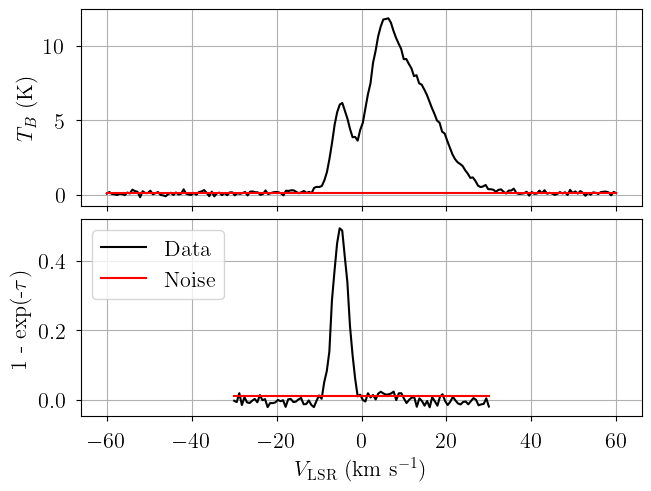

In [5]:
# Plot data
fig, axes = plt.subplots(2, layout="constrained", sharex=True)
axes[0].plot(data["emission"].spectral, data["emission"].brightness, "k-")
axes[0].plot(data["emission"].spectral, data["emission"].noise, "r-")
axes[1].plot(data["absorption"].spectral, data["absorption"].brightness, "k-", label="Data")
axes[1].plot(data["absorption"].spectral, data["absorption"].noise, "r-", label="Noise")
axes[1].set_xlabel(data["emission"].xlabel)
axes[0].set_ylabel(data["emission"].ylabel)
axes[1].set_ylabel(data["absorption"].ylabel)
_ = axes[1].legend(loc="upper left")

## `Optimize`

We use the `Optimize` class for optimization.

In [7]:
from bayes_spec import Optimize

# Initialize optimizer
opt = Optimize(
    EmissionAbsorptionPhysicalModel,  # model definition
    data,  # data dictionary
    max_n_clouds=5,  # maximum number of clouds
    baseline_degree=baseline_degree,  # polynomial baseline degree
    depth_nth_fwhm_power = 1/3, # assumed non-thermal FWHM vs. depth power law index
    bg_temp=3.77,  # assumed background brightness temperature (K)
    seed=1234,  # random seed
    verbose=True,  # verbosity
)

# Define each model
opt.add_priors(
    prior_sigma_log10_NHI=0.5, # log-normal column density distribution width
    prior_ff_NHI=1.0e21, # filling factor * column density prior width (cm-2)
    prior_fwhm2=500.0, # FWHM^2 prior width (km2 s-2)
    prior_fwhm2_thermal_fraction=[2.0, 2.0], # thermal FWHM^2 fraction prior shape
    prior_velocity=[0.0, 10.0], # velocity prior mean and width (km/s)
    prior_log10_n_alpha=[-6.0, 2.0], # log10(n_alpha) prior mean and width (cm-3)
    prior_nth_fwhm_1pc=[1.75, 0.25], # non-thermal FWHM at 1 pc prior mean and width (km s-1)
    prior_fwhm_L=None, # Assume Gaussian line profile
    prior_baseline_coeffs=None, # Default baseline priors
)
opt.add_likelihood()

`Optimize` has created `max_n_clouds` models, where `opt.models[1]` has `n_clouds=1`, `opt.models[2]` has `n_clouds=2`, etc.

In [8]:
print(opt.models[4])
print(opt.models[4].n_clouds)

4


By default (`approx=True`), the optimization algorithm first loops over every model and approximates the posterior distribution using variational inference. This is generally a bad idea, since VI is only an approximation and tends to struggle with complex models. Instead we use `approx=False` to sample every model with MCMC. This is slower but more robust.

We can supply arguments to `fit` and `sample` via dictionaries. Whichever model is the first to have a BIC within `bic_threshold` of the minimum BIC is the "best" model. The algorithm will terminate early if successive models have increasing BICs or fail to converge.

In [9]:
fit_kwargs = {
    "rel_tolerance": 0.05,
    "abs_tolerance": 0.05,
    "learning_rate": 0.01,
}
sample_kwargs = {
    "chains": 8,
    "cores": 8,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(
    bic_threshold=10.0,
    sample_kwargs=sample_kwargs,
    fit_kwargs=fit_kwargs,
    approx=False,
    start_spread = {"velocity_norm": [-1.0, 1.0]},
)

Null hypothesis BIC = 2.126e+05
Sampling n_cloud = 1 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 4800
Interrupted at 4,799 [4%]: Average Loss = 52,599
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_emission_norm, baseline_absorption_norm, fwhm2_norm, velocity_norm, log10_n_alpha_norm, nth_fwhm_1pc, ff_NHI_norm, fwhm2_thermal_fraction_norm, filling_factor_norm, log10_wt_ff_fwhm2_thermal]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 6 seconds.


Adding log-likelihood to trace


Output()

There were 7 divergences in converged chains.
GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = 1.854e+04

Sampling n_cloud = 2 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 7400
Interrupted at 7,399 [7%]: Average Loss = 74,216
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_emission_norm, baseline_absorption_norm, fwhm2_norm, velocity_norm, log10_n_alpha_norm, nth_fwhm_1pc, ff_NHI_norm, fwhm2_thermal_fraction_norm, filling_factor_norm, log10_wt_ff_fwhm2_thermal]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 28 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = 3.008e+03

Sampling n_cloud = 3 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 7200
Interrupted at 7,199 [7%]: Average Loss = 1.5246e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_emission_norm, baseline_absorption_norm, fwhm2_norm, velocity_norm, log10_n_alpha_norm, nth_fwhm_1pc, ff_NHI_norm, fwhm2_thermal_fraction_norm, filling_factor_norm, log10_wt_ff_fwhm2_thermal]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 37 seconds.


Adding log-likelihood to trace


Output()

There were 64 divergences in converged chains.
GMM converged to unique solution
n_cloud = 3 solution = 0 BIC = -8.161e+02

Sampling n_cloud = 4 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 8500
Interrupted at 8,499 [8%]: Average Loss = 2.2165e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_emission_norm, baseline_absorption_norm, fwhm2_norm, velocity_norm, log10_n_alpha_norm, nth_fwhm_1pc, ff_NHI_norm, fwhm2_thermal_fraction_norm, filling_factor_norm, log10_wt_ff_fwhm2_thermal]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 50 seconds.


Adding log-likelihood to trace


Output()

There were 426 divergences in converged chains.
GMM converged to unique solution
n_cloud = 4 solution = 0 BIC = -7.710e+02

Stopping criteria met.
Sampling n_cloud = 5 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 14800
Interrupted at 14,799 [14%]: Average Loss = 1.7483e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_emission_norm, baseline_absorption_norm, fwhm2_norm, velocity_norm, log10_n_alpha_norm, nth_fwhm_1pc, ff_NHI_norm, fwhm2_thermal_fraction_norm, filling_factor_norm, log10_wt_ff_fwhm2_thermal]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 379 seconds.


Adding log-likelihood to trace


Output()

There were 676 divergences in converged chains.
No solution found!
0 of 8 chains appear converged.

Stopping criteria met.
Stopping early.


In [10]:
opt.best_model.n_clouds

3

Sampling: [absorption, emission]


Output()

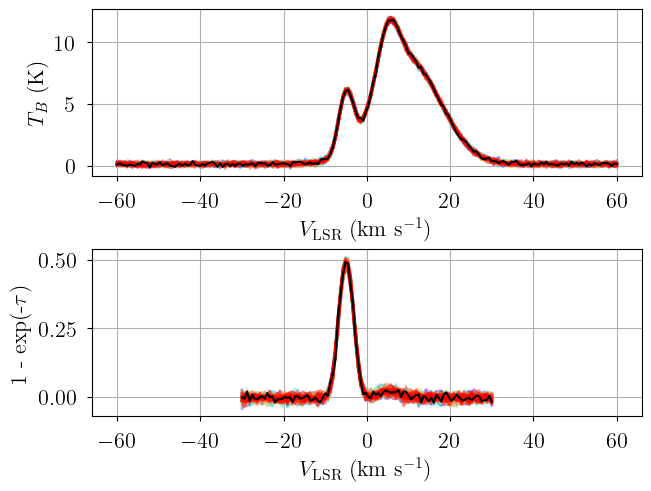

In [11]:
from bayes_spec.plots import plot_predictive

posterior = opt.best_model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
axes = plot_predictive(opt.best_model.data, posterior.posterior_predictive)
axes.ravel()[0].sharex(axes.ravel()[1])